In [1]:
!python -V

Python 3.9.19


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-mlops")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1721336176115, experiment_id='1', last_update_time=1721336176115, lifecycle_stage='active', name='nyc-taxi-mlops', tags={}>

In [7]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

/tmp/ipykernel_102317/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_102317/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


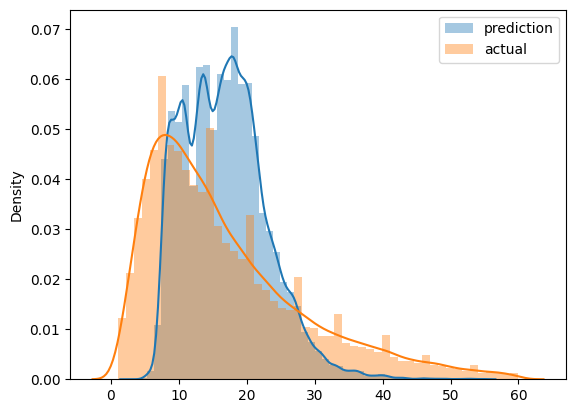

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

# Lasso Mlflow Sample

- Log params
    - Hyperparams
    - Data paths

- Log metrics

In [18]:
with mlflow.start_run():

    mlflow.set_tag("developer",  "tag")

    mlflow.log_param("train-data-path", './data/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path", './data/green_tripdata_2021-02.parquet')

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

# Hyperparameter Tuning

- Use hyperopt

In [19]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [20]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [21]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
    return {"loss": rmse, "status": STATUS_OK}

In [22]:
search_space = {
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 100)),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'alpha': hp.loguniform('alpha', -10, 10),
    'lambda': hp.loguniform('lambda', -10, 10),
    'objective': 'reg:linear',
    'seed': 123,
}

In [23]:
best_params = fmin(
fn=objective,
space=search_space,
algo=tpe.suggest,
max_evals=10,
trials=Trials()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:03:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.31535                           
[1]	validation-rmse:8.00717                           
[2]	validation-rmse:7.41763                           
[3]	validation-rmse:7.13231                           
[4]	validation-rmse:6.99621                           
[5]	validation-rmse:6.92230                           
[6]	validation-rmse:6.88814                           
[7]	validation-rmse:6.85331                           
[8]	validation-rmse:6.84290                           
[9]	validation-rmse:6.84290                           
[10]	validation-rmse:6.83631                          
[11]	validation-rmse:6.82184                          
[12]	validation-rmse:6.81782                          
[13]	validation-rmse:6.81750                          
[14]	validation-rmse:6.80656                          
[15]	validation-rmse:6.81382                          
[16]	validation-rmse:6.80696                          
[17]	validation-rmse:6.79252                          
[18]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:04:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.55641                                                    
[3]	validation-rmse:7.20780                                                    
[4]	validation-rmse:7.03212                                                    
[5]	validation-rmse:6.93901                                                    
[6]	validation-rmse:6.88893                                                    
[7]	validation-rmse:6.85396                                                    
[8]	validation-rmse:6.82790                                                    
[9]	validation-rmse:6.80964                                                    
[10]	validation-rmse:6.80848                                                   
[11]	validation-rmse:6.80382                                                   
[12]	validation-rmse:6.79603                                                   
[13]	validation-rmse:6.78735                                                   
[14]	validation-rmse:6.78443            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:05:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.72684                                                    
[1]	validation-rmse:7.41035                                                    
[2]	validation-rmse:6.94849                                                    
[3]	validation-rmse:6.77169                                                    
[4]	validation-rmse:6.69486                                                    
[5]	validation-rmse:6.65402                                                    
[6]	validation-rmse:6.62852                                                    
[7]	validation-rmse:6.60655                                                    
[8]	validation-rmse:6.59609                                                    
[9]	validation-rmse:6.59152                                                    
[10]	validation-rmse:6.58743                                                   
[11]	validation-rmse:6.58571                                                   
[12]	validation-rmse:6.58380            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:05:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74490                                                   
[1]	validation-rmse:11.31156                                                   
[2]	validation-rmse:10.90792                                                   
[3]	validation-rmse:10.83247                                                   
[4]	validation-rmse:10.46658                                                   
[5]	validation-rmse:10.12945                                                   
[6]	validation-rmse:9.81778                                                    
[7]	validation-rmse:9.53104                                                    
[8]	validation-rmse:9.26626                                                    
[9]	validation-rmse:9.21765                                                    
[10]	validation-rmse:8.98125                                                   
[11]	validation-rmse:8.76295                                                   
[12]	validation-rmse:8.56235            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:09:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.94362                                                     
[1]	validation-rmse:8.71791                                                     
[2]	validation-rmse:8.02072                                                     
[3]	validation-rmse:7.91496                                                     
[4]	validation-rmse:7.53392                                                     
[5]	validation-rmse:7.29488                                                     
[6]	validation-rmse:7.14484                                                     
[7]	validation-rmse:7.03308                                                     
[8]	validation-rmse:6.96222                                                     
[9]	validation-rmse:6.92539                                                     
[10]	validation-rmse:6.89828                                                    
[11]	validation-rmse:6.86787                                                    
[12]	validation-rmse:6.82944